In [1]:
from __future__ import division

import pandas as pd
from sklearn import model_selection
from sklearn.model_selection import StratifiedKFold
import sklearn
import math
import string
import random
import numpy as np

SEED = 7

from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [3]:
import xgboost as xgb
from xgboost import XGBClassifier

In [4]:
!pip install tpot
import tpot
from tpot import TPOTClassifier

C:\Users\Hadamard\anaconda3\lib\site-packages\tpot\builtins\__init__.py:36: UserWarning: Warning: optional dependency `torch` is not available. - skipping import of NN models.
  warnings.warn("Warning: optional dependency `torch` is not available. - skipping import of NN models.")


# A partir de statistiques issues des matchs, on veut savoir si un rookie de NBA (joueur qui effectue sa première année) va durer plus de 5 ans



In [5]:
import os

os.chdir('C:\\Users\\Hadamard\\Downloads\\Test Data Science')

In [6]:
nba = pd.read_csv('nba_logreg.csv')

In [7]:
nba.head()

,Name,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,3P%,...,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV,TARGET_5Yrs
0,Brandon Ingram,36,27.4,7.4,2.6,7.6,34.7,0.5,2.1,25.0,...,2.3,69.9,0.7,3.4,4.1,1.9,0.4,0.4,1.3,0.0
1,Andrew Harrison,35,26.9,7.2,2.0,6.7,29.6,0.7,2.8,23.5,...,3.4,76.5,0.5,2.0,2.4,3.7,1.1,0.5,1.6,0.0
2,JaKarr Sampson,74,15.3,5.2,2.0,4.7,42.2,0.4,1.7,24.4,...,1.3,67.0,0.5,1.7,2.2,1.0,0.5,0.3,1.0,0.0
3,Malik Sealy,58,11.6,5.7,2.3,5.5,42.6,0.1,0.5,22.6,...,1.3,68.9,1.0,0.9,1.9,0.8,0.6,0.1,1.0,1.0
4,Matt Geiger,48,11.5,4.5,1.6,3.0,52.4,0.0,0.1,0.0,...,1.9,67.4,1.0,1.5,2.5,0.3,0.3,0.4,0.8,1.0


<AxesSubplot:>

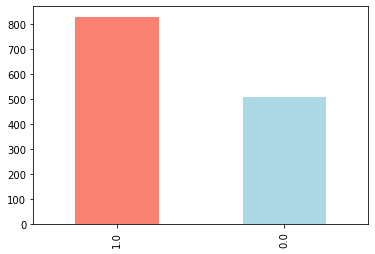

In [8]:
nba["TARGET_5Yrs"].value_counts().plot(kind="bar", color=["salmon", "lightblue"])

# On constate qu'il y a environ 50% de plus de joueurs qui ont confirmé au bout de 5 ans en NBA. 

# Obtenons la répartition statistique des features à notre disposition puis leur matrice de corrélation

In [9]:
nba.describe()

,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,3P%,FTM,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV,TARGET_5Yrs
count,1340.000000,1340.000000,1340.000000,1340.000000,1340.000000,1340.000000,1340.000000,1340.000000,1329.000000,1340.000000,1340.000000,1340.000000,1340.000000,1340.000000,1340.000000,1340.000000,1340.000000,1340.000000,1340.000000,1340.000000
mean,60.414179,17.624627,6.801493,2.629104,5.885299,44.169403,0.247612,0.779179,19.308126,1.297687,1.821940,70.300299,1.009403,2.025746,3.034478,1.550522,0.618507,0.368582,1.193582,0.620149
std,17.433992,8.307964,4.357545,1.683555,3.593488,6.137679,0.383688,1.061847,16.022916,0.987246,1.322984,10.578479,0.777119,1.360008,2.057774,1.471169,0.409759,0.429049,0.722541,0.485531
min,11.000000,3.100000,0.700000,0.300000,0.800000,23.800000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.200000,0.300000,0.000000,0.000000,0.000000,0.100000,0.000000
25%,47.000000,10.875000,3.700000,1.400000,3.300000,40.200000,0.000000,0.000000,0.000000,0.600000,0.900000,64.700000,0.400000,1.000000,1.500000,0.600000,0.300000,0.100000,0.700000,0.000000
50%,63.000000,16.100000,5.550000,2.100000,4.800000,44.100000,0.100000,0.300000,22.400000,1.000000,1.500000,71.250000,0.800000,1.700000,2.500000,1.100000,0.500000,0.200000,1.000000,1.000000
75%,77.000000,22.900000,8.800000,3.400000,7.500000,47.900000,0.400000,1.200000,32.500000,1.600000,2.300000,77.600000,1.400000,2.600000,4.000000,2.000000,0.800000,0.500000,1.500000,1.000000
max,82.000000,40.900000,28.200000,10.200000,19.800000,73.700000,2.300000,6.500000,100.000000,7.700000,10.200000,100.000000,5.300000,9.600000,13.900000,10.600000,2.500000,3.900000,4.400000,1.000000


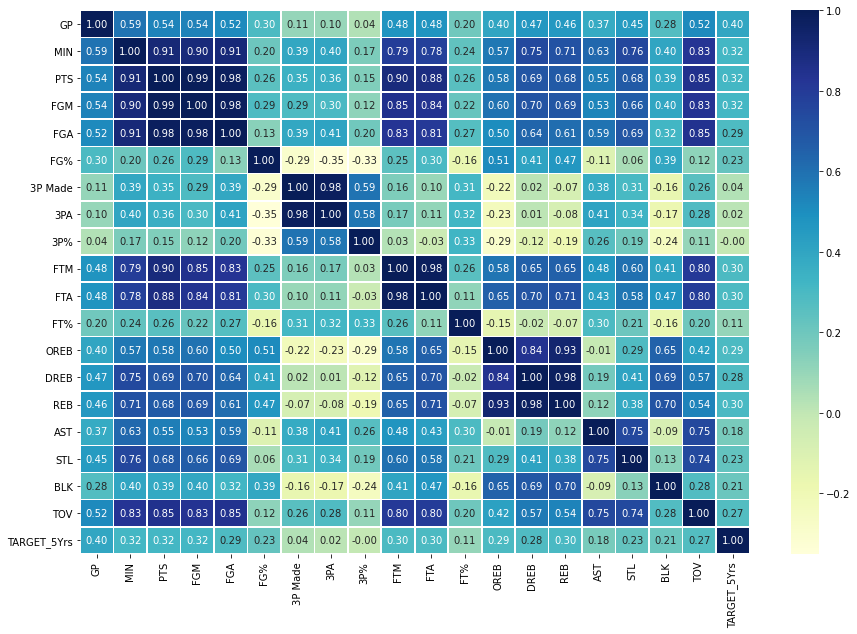

In [10]:
import seaborn as sns

corr_matrix = nba.corr()
fig, ax = plt.subplots(figsize=(15,10))
ax = sns.heatmap(corr_matrix, annot=True, linewidths=0.6, fmt=".2f", cmap="YlGnBu")

# On constate que certaines features sont fortement corrélées ; par exemple, le nombre de minutes jouées et le nombre de points ou le nombre de tirs réussis et le nombre de points (ce qui n'est pas étonnant car un tir vaut systématiquement 2 ou 3 points)

In [11]:
nba.drop(labels='Name', axis=1, inplace=True)

In [12]:
nba.head()

,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,3P%,FTM,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV,TARGET_5Yrs
0,36,27.4,7.4,2.6,7.6,34.7,0.5,2.1,25.0,1.6,2.3,69.9,0.7,3.4,4.1,1.9,0.4,0.4,1.3,0.0
1,35,26.9,7.2,2.0,6.7,29.6,0.7,2.8,23.5,2.6,3.4,76.5,0.5,2.0,2.4,3.7,1.1,0.5,1.6,0.0
2,74,15.3,5.2,2.0,4.7,42.2,0.4,1.7,24.4,0.9,1.3,67.0,0.5,1.7,2.2,1.0,0.5,0.3,1.0,0.0
3,58,11.6,5.7,2.3,5.5,42.6,0.1,0.5,22.6,0.9,1.3,68.9,1.0,0.9,1.9,0.8,0.6,0.1,1.0,1.0
4,48,11.5,4.5,1.6,3.0,52.4,0.0,0.1,0.0,1.3,1.9,67.4,1.0,1.5,2.5,0.3,0.3,0.4,0.8,1.0


In [13]:
from sklearn import preprocessing

In [14]:
data = nba.values

# Il y a beaucoup de features qui ont une distribution approximativement normale comme le pourcentage de réussite au tir, donc j'ai préféré remplacer le MinMaxScaler par le StandardScaler 

<AxesSubplot:ylabel='Frequency'>

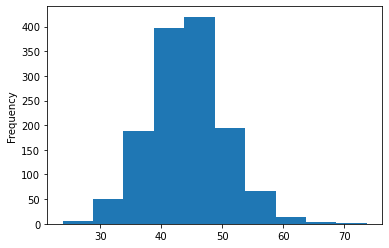

In [45]:
nba["FG%"].plot(kind="hist")

# Dans chaque colonne, on remplace les NaN par la valeur la plus fréquente

In [15]:
from sklearn import impute
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, QuantileTransformer

imputer = SimpleImputer(strategy='most_frequent')
imputer = imputer.fit(data)
data = imputer.transform(data)

In [16]:
X = data[:, 0:19]
Y = data[:, 19]

In [17]:
X

array([[36. , 27.4,  7.4, ...,  0.4,  0.4,  1.3],
       [35. , 26.9,  7.2, ...,  1.1,  0.5,  1.6],
       [74. , 15.3,  5.2, ...,  0.5,  0.3,  1. ],
       ...,
       [43. , 12.1,  5.4, ...,  0.3,  0.4,  0.9],
       [52. , 12. ,  4.5, ...,  0.4,  0.1,  0.8],
       [47. , 11.7,  4.4, ...,  0.7,  0.1,  0.9]])

In [18]:
Y

array([0., 0., 0., ..., 0., 1., 1.])

In [19]:
Y = Y.astype(int)

In [20]:
# as said before,  we will use 20% of the dataset for validation
validation_size = 0.20

# split the data into traning and testing
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=validation_size, random_state=SEED)

#y = nba['TARGET_5Yrs']
#X = nba.drop(labels='TARGET_5Yrs',axis=1)

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [21]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform (X_test)

In [22]:
nba.groupby('TARGET_5Yrs').size()

TARGET_5Yrs
0.0    509
1.0    831
dtype: int64

In [23]:
from sklearn.utils.multiclass import type_of_target
type_of_target(Y)

'binary'

# Maintenant on peut passer à l'entraînement des modèles : j'ai choisi des algorithmes usuels pour la classification binaire et j'ai cherché la combinaison optimale (pour l'accuracy) des hyperparamètres indiqués avec une recherche en grille (GridSearch)

In [24]:
from pandas.plotting import scatter_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.ensemble import BaggingClassifier

models = []
models.append(('LR', LogisticRegression(solver='lbfgs',max_iter=10000,C=1)))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier(n_neighbors=30)))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC(gamma='auto',kernel='linear',C=1)))
models.append(('ET', ExtraTreesClassifier()))
models.append(('AB', AdaBoostClassifier(n_estimators = 60 , learning_rate = 0.3)))
models.append(('RF', RandomForestClassifier(max_features=0.85)))
models.append(('Ridge', RidgeClassifier(alpha=6.3)))
models.append(('MLPC', MLPClassifier(hidden_layer_sizes=(100,100), max_iter=1000,activation = 'relu',solver='adam',random_state=1)))
#models.append(('XGB', XGBClassifier(use_label_encoder="False",eval_metric='logloss')))
#models.append(('TPOT', TPOTClassifier(generations=5,population_size=20,verbosity=2,n_jobs=-1)))

# Comme il y a plus de 50% en plus de rookies qui ont confirmé après 5 ans, j'ai remplacé le KFold proposé pour la validation croisée par StratifiedKFold qui va conserver la proportion de chaque classe dans les blocs et j'ai augmenté le nombre de blocs de 3 à 10 

In [25]:
scoring = 'accuracy'
models_results = []
for name, model in models:
    results = []
    skfolds = StratifiedKFold(n_splits=10,random_state=SEED,shuffle=True)
    for train_index, test_index in skfolds.split(X_train, Y_train):
        X_train_folds = X_train[train_index]
        Y_train_folds = (Y_train[train_index])
        X_test_folds = X_train[test_index]
        Y_test_folds = (Y_train[test_index])

        model.fit(X_train_folds, Y_train_folds)
        pred = model.predict(X_test_folds)
        correct = sum(pred == Y_test_folds)
        results.append(correct / len(pred))
    models_results.append((name, results))


names = []
scores = []
# the snippet bellow calculates the mean of the accuracies
for name, results in models_results:
    mean = np.array(results).mean()
    std = np.array(results).std()
    print("Model: %s, Accuracy Mean: %f (%f)" % (name, mean, std,))
    names.append(name)
    scores.append(results)


Model: LR, Accuracy Mean: 0.711743 (0.037529)
Model: LDA, Accuracy Mean: 0.707087 (0.034508)
Model: KNN, Accuracy Mean: 0.685609 (0.035086)
Model: CART, Accuracy Mean: 0.621192 (0.032110)
Model: NB, Accuracy Mean: 0.638032 (0.035904)
Model: SVM, Accuracy Mean: 0.709839 (0.044919)
Model: ET, Accuracy Mean: 0.694055 (0.043169)
Model: AB, Accuracy Mean: 0.700537 (0.052981)
Model: RF, Accuracy Mean: 0.701488 (0.037860)
Model: Ridge, Accuracy Mean: 0.708004 (0.042526)
Model: MLPC, Accuracy Mean: 0.643657 (0.045334)


In [26]:
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score

def score_classifier(dataset,classifier,labels):

    """
    performs 3 random trainings/tests to build a confusion matrix and prints results with precision and recall scores
    :param dataset: the dataset to work on
    :param classifier: the classifier to use
    :param labels: the labels used for training and validation
    :return:
    """

    kf = StratifiedKFold(n_splits=10,random_state=SEED,shuffle=True)
    confusion_mat = np.zeros((2,2))
    recalls = []
    for training_ids,test_ids in kf.split(dataset,labels):
        training_set = dataset[training_ids]
        training_labels = labels[training_ids]
        test_set = dataset[test_ids]
        test_labels = labels[test_ids]
        classifier.fit(training_set,training_labels)
        predicted_labels = classifier.predict(test_set)
        confusion_mat+=confusion_matrix(test_labels,predicted_labels)
        recalls.append(recall_score(test_labels, predicted_labels))
    #print(confusion_mat)
    return(recalls)



In [27]:
liste_recalls = []

for name, model in models:
    liste_recalls.append(score_classifier(X,model,Y))
    

In [28]:
liste_recalls

[[0.8795180722891566,
  0.8313253012048193,
  0.8192771084337349,
  0.7590361445783133,
  0.891566265060241,
  0.7831325301204819,
  0.8072289156626506,
  0.8554216867469879,
  0.8313253012048193,
  0.7738095238095238],
 [0.8674698795180723,
  0.8554216867469879,
  0.8192771084337349,
  0.7951807228915663,
  0.8674698795180723,
  0.8192771084337349,
  0.8192771084337349,
  0.8674698795180723,
  0.8554216867469879,
  0.7619047619047619],
 [0.8433734939759037,
  0.7951807228915663,
  0.8313253012048193,
  0.7349397590361446,
  0.7590361445783133,
  0.6987951807228916,
  0.8072289156626506,
  0.7831325301204819,
  0.7951807228915663,
  0.75],
 [0.6626506024096386,
  0.6265060240963856,
  0.6746987951807228,
  0.6385542168674698,
  0.6626506024096386,
  0.5903614457831325,
  0.7469879518072289,
  0.7108433734939759,
  0.6144578313253012,
  0.6904761904761905],
 [0.5903614457831325,
  0.5060240963855421,
  0.4939759036144578,
  0.4578313253012048,
  0.4939759036144578,
  0.5060240963855421,

In [29]:
scores

[[0.7407407407407407,
  0.6944444444444444,
  0.6728971962616822,
  0.7757009345794392,
  0.7757009345794392,
  0.7009345794392523,
  0.6728971962616822,
  0.6728971962616822,
  0.7009345794392523,
  0.7102803738317757],
 [0.7222222222222222,
  0.6944444444444444,
  0.6822429906542056,
  0.7570093457943925,
  0.7663551401869159,
  0.7009345794392523,
  0.6635514018691588,
  0.6542056074766355,
  0.7102803738317757,
  0.719626168224299],
 [0.7407407407407407,
  0.6574074074074074,
  0.7009345794392523,
  0.719626168224299,
  0.719626168224299,
  0.6728971962616822,
  0.616822429906542,
  0.6915887850467289,
  0.6542056074766355,
  0.6822429906542056],
 [0.6481481481481481,
  0.6759259259259259,
  0.6261682242990654,
  0.6448598130841121,
  0.616822429906542,
  0.6261682242990654,
  0.5887850467289719,
  0.6355140186915887,
  0.5887850467289719,
  0.5607476635514018],
 [0.6481481481481481,
  0.6574074074074074,
  0.6635514018691588,
  0.7009345794392523,
  0.5794392523364486,
  0.6355140

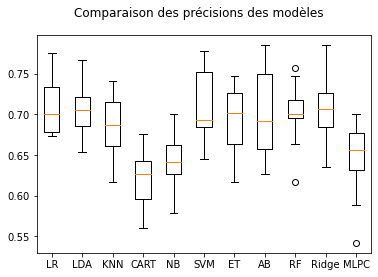

In [30]:
fig = plt.figure()
fig.suptitle('Comparaison des précisions des modèles')
ax = fig.add_subplot(111)
plt.boxplot(scores)
ax.set_xticklabels(names)
plt.show()
plt.close()

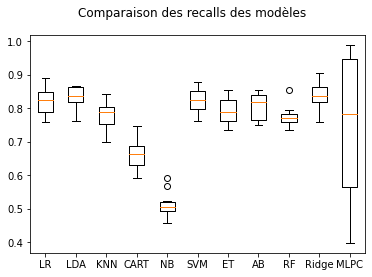

In [31]:
fig = plt.figure()
fig.suptitle('Comparaison des recalls des modèles')
ax = fig.add_subplot(111)
plt.boxplot(liste_recalls)
ax.set_xticklabels(names)
plt.show()
plt.close()

In [32]:
!pip install flask
import flask

In [33]:
clf = SVC(gamma='auto',kernel='linear',C=1)
skfolds = StratifiedKFold(n_splits=10,random_state=SEED,shuffle=True)
for train_index, test_index in skfolds.split(X_train, Y_train):
    X_train_folds = X_train[train_index]
    Y_train_folds = (Y_train[train_index])
    X_test_folds = X_train[test_index]
    Y_test_folds = (Y_train[test_index])
    clf.fit(X_train_folds, Y_train_folds)

In [34]:
import pickle
pickle.dump(clf,open('model.pkl','wb'))
model = pickle.load(open('model.pkl','rb'))

In [36]:
data = [[9.34, 1.68, 2.7, 25.0, 98.0, 2.8, 1.31, 0.53, 2.7, 13.0, 0.57, 1.96, 660.0, 0, 0, 14, 14, 12, 12]]

print(model.predict(data))

[1]


In [41]:
nba.drop(labels='TARGET_5Yrs', axis=1, inplace=True)

In [42]:
features_names = nba.columns

# Après avoir examiné les performances des algorithmes en précision et recall, on retient le modèle SVM qu'on exporte avec le module pickle afin de l'intégrer dans une API avec Flask. Ce diagramme en barres montre l'importance de chaque variable (les poids qui leur ont été assignés pendant l'entraînement)

<AxesSubplot:>

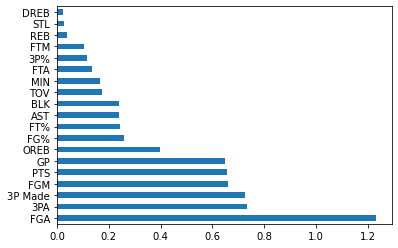

In [46]:
pd.Series(abs(clf.coef_[0]), index=features_names).nlargest(19).plot(kind='barh')